This business problem is related with multiple stakeholders including Product, Sales, and Customer Success teams. Each team has different requirements and use cases. Basically we need to answer the following questions:
1. what metrics to use to evaluate a facility's "quality"?
2. find straightforward ways to tell good quality facility from bad ones
3. find which factors contribute most to the good/bad quality of a facility, so that facility can improve on those factors.
4. predict the quality of a new facility so that SpotHero can prioritize how to expand in a market

In [41]:
# prepare packages and environment, set up configuration
# !pip install shap
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
import shap
import xgboost
from scipy import stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
rs = 10   # random state

In [43]:
df = pd.read_csv('SpotHero_Take_Home_Quality_Facility_Data_2_2023_-_ranking.csv')
df.head()

,facility_id,reporting_neighborhood,city,latitude,longitude,height_restriction,ext_allowed,parking_type,accessible,ev_charging,heated,rooftop_exposed,has_monthly_rates,has_transient_rates,p4w_total_gross_revenue,p4w_new_drivers,p4w_repeat_drivers,num_words_parking_instruction,num_rentals_refunded,p4w_sipp,sipp,user_issues_per_park,tipp,product_cpp,total_cpp,p4w_lot_full,num_stalls,count_first_rentals,count_repeat,rental_count,p4w_return_pct,scan_to_pay_flag,iq_facility,p4w_total_gross_revenue_no_event,customer_reviews_count,covered_parking,inout_allowed,lot_fulls_per_park,utilization,utilization_weekday_day,utilization_weekend_night,has_event_rates,searches,on_site_staff,facility_type_under_el,facility_type_garage,facility_type_valet_stand,facility_type_lot,facility_type_personal_spot,refund_pct,average_star_rating
0,1,United Center,Chicago,41.88,-87.67,NaN,True,self,True,False,False,False,False,True,90.00,5.00,1.00,55,1,0.00,0,0,0,0,0,0,1,2,2,7,16.7%,False,False,0.00,4,False,True,0,0.02,0.01,0.10,True,1002,False,0,0,0,1,0,14.29%,5.00
1,2,Lincoln Park,Chicago,41.92,-87.65,NaN,True,self,False,False,False,False,False,True,263.50,13.00,2.00,74,1,0.00,1000,0,0,0,1000,0,1,1,1,16,13.3%,False,True,263.50,14,False,True,500,0.20,0.14,0.57,False,1675,False,0,0,0,1,0,6.25%,4.30
2,3,Wrigleyville,Chicago,41.95,-87.66,NaN,True,self,True,False,False,False,False,True,0.00,NaN,NaN,56,0,0.00,0,0,0,0,1000,0,1,1,1,0,0.0%,False,False,NaN,13,False,True,0,0.04,0.02,0.09,True,18988,False,0,0,0,0,1,0.00%,4.20
3,4,South Loop,Chicago,41.87,-87.63,90.00,True,self,True,True,False,False,False,True,5421.00,87.00,115.00,63,10,3.26,214,500,71,143,1214,1,40,6155,5659,663,56.9%,False,False,4851.00,4320,True,False,71,0.41,0.80,0.24,True,4056,True,0,1,0,0,0,1.51%,4.80
4,5,Near North,Chicago,41.90,-87.64,74.00,True,self,True,False,False,False,True,True,4338.00,91.00,69.00,35,17,34.59,417,167,0,167,1000,2,20,3309,3015,305,43.1%,False,False,4338.00,1775,False,True,83,0.29,0.99,0.23,False,20114,False,0,0,0,1,0,5.57%,4.80


by browsing the given PDF document and dataframe, we decide the following metrics are good indicator of a facility's quality:
1. Average star rating of the facility given by drivers of SpotHero
2. ratio of returned drivers. number of returned drivers divided by total drivers. because drivers are more likely to return to good quality parking lots.

In [44]:
# Average star rating of the facility
df['average_star_rating']

# ratio of returned drivers = p4w_repeat_drivers / (p4w_repeat_drivers + p4w_new_drivers)
# there are null values in p4w_new_drivers and p4w_repeat_drivers, fill them with zero. return_ratio is zero if any one of the two columns are zero.
df['p4w_new_drivers'] = df['p4w_new_drivers'].fillna(0)
df['p4w_repeat_drivers'] = df['p4w_repeat_drivers'].fillna(0)
df['return_ratio'] = df['p4w_repeat_drivers'].div(df['p4w_repeat_drivers'] + df['p4w_new_drivers']).replace(np.nan, 0)

In [45]:
# calculate correlation between return_ratio and average_star_rating
print(df['return_ratio'].corr(df['average_star_rating']))

0.27420726948552393


we can see return_ratio is positively correlated with average_star_rating. <br>
Among them, stakeholders can choose different metrics for different business purposes, and differentiate good quality facility from bad ones.

in general revenue/profit could also be indicator of quality. good quality facility usually has a higher demand, thus resulting a higher revenue. But price is highly related with location of a facility. Parking lot in downtown area usually charges higher fee, also has more customers. So we do not use revenue/profit as metrics for now.

To answer question 3 and 4, we need to build a model. The purpose of the model is to predict a facility's quality given its operating numbers and service conditions, e.g, are there any issues, does the facility provide certain service, etc. I will use average_star_rating as the label here. Same can be applied to return_ratio. <br>
since rating numbers can be sorted or compared to each other, we can view it as continuous quantity, so we will use a regression model.

In [6]:
label = 'average_star_rating'

Many factors can contribute to the quality of a facility. We pick all the features from the dataset that could potentially strengthen or weaken a parking lot's quality, and separate them into 3 groups.

In [46]:
categorical_features = [
    'reporting_neighborhood',
    'parking_type',
]

sequence_features = [
    'height_restriction',
    'p4w_sipp',
    'sipp',
    'user_issues_per_park',
    'tipp',
    'lot_fulls_per_park',
    'utilization',
    'utilization_weekday_day',
    'utilization_weekend_night',
    'p4w_return_pct',
    'refund_pct',
    'num_stalls'
]

binary_features = [
    'ext_allowed',
    'accessible',
    'ev_charging',
    'heated',
    'rooftop_exposed', 
    'has_monthly_rates',
    'has_transient_rates',
    'scan_to_pay_flag',
    'covered_parking',
    'inout_allowed',
    'on_site_staff',
    'facility_type_under_el',
    'facility_type_garage',
    'facility_type_valet_stand',
    'facility_type_lot',
    'facility_type_personal_spot',
    'iq_facility'

]

features = categorical_features + sequence_features + binary_features
df = df[features + [label]]

There is only 1 city in the entire dataset, so we ignore city column.<br> 
p4w_lot_full is Number of Lot Full incidents in the last 4 weeks. In general large facilities have more customers, so they natually have a higher Lot Full incidents count. lot_fulls_per_park is a better feature to measure facility's management level. For same reason we exclude num_rentals_refunded.

Next we will preprocess the dataset. <br>
height_restriction column has many null values. For now we assume these facilities don't have height limit. We have different ways to deal with it. We can convert this sequence feature to buckets, and the highest bucket is "greater than certain value". Or we can fill them with a large number. Since the max of height_restriction column is 132, we assign 150 to the null ones. <br>
There are also null values in average_star_rating column. since we cannot make up values for the rating, we ignore the 36 rows.

In [47]:
df.loc[:,'height_restriction'] = df['height_restriction'].fillna(150)
df.loc[:,'utilization_weekday_day'] = df['utilization_weekday_day'].fillna(0.0)
df.loc[:,'utilization_weekend_night'] = df['utilization_weekend_night'].fillna(0.0)
df = df.dropna(subset=['average_star_rating'])

columns with "per park" are by 1000 parks, so we divide them by 1000.<br> 
we will convert categorical and binary columns to int type. <br>

In [48]:
rescale_columns = [
    'p4w_sipp',
    'sipp',
    'user_issues_per_park',
    'tipp',
    'lot_fulls_per_park',
]

for c in rescale_columns:
    df[c] = df[c] / 1000
for c in categorical_features:
    df[c] = LabelEncoder().fit_transform(df[c]).astype('int')
for c in binary_features:
    df[c] = df[c].astype(int)

p4w_return_pct and refund_pct columns are in string format. we need to convert them to float. also remove invalid records where the percentage is greater than 100%.

In [49]:
string_columns = ['p4w_return_pct', 'refund_pct']
for c in string_columns:
    df[c] = df[c].str.rstrip('%').astype('float') / 100.0
    df = df[df[c] <= 1]

Next we need to build a baseline model, and we will evaluate future models against the baseline. <br>

In [36]:
df['average_star_rating'].describe()

count   653.00
mean      4.63
std       0.33
min       1.00
25%       4.60
50%       4.70
75%       4.80
max       5.00
Name: average_star_rating, dtype: float64

The mean of all rating numbers is 4.6. So in the baseline model, we always predict 4.6 regardless of the given features. And we use RMSE to calculate the loss.

In [38]:
y_pred = [4.6] * df.shape[0]
print(mean_squared_error(df[label], y_pred, squared=False))

0.3287174016818296


baseline model has RMSE of 0.329<br>
to calculate accuracy, we round the predicted rating number and true label to whole number.

In [68]:
y_pred_round = [round(i) for i in y_pred]
df_label_round = df[label].round(0)
print(accuracy_score(df_label_round, y_pred_round))

0.774885145482389


baseline model's accuracy is 0.77

To build our model, we first use a xgboost regressor.

In [50]:
estimator = xgboost.XGBRegressor()

Next we do feature engineering. We normalize the categorical and sequence features.

In [51]:
scaler = MinMaxScaler()
df[sequence_features + categorical_features] = scaler.fit_transform(df[sequence_features + categorical_features])

We also remove highly correlated columns. If two columns have correlation greater than 0.85, we only keep one of them.

<AxesSubplot:>

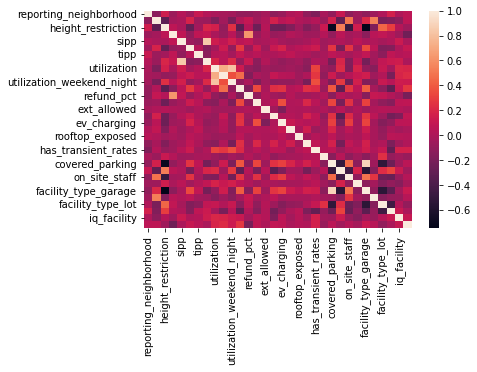

In [52]:
sns.heatmap(df.corr())

In [53]:
# drop unnecessary columns due to high correlation to other columns
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(to_drop)
df = df.drop(to_drop, axis=1)
binary_features = [i for i in binary_features if i not in to_drop]
features = [i for i in features if i not in to_drop]

['facility_type_garage']


After working on the features, we split the dataset into training and testing data. testing data is 20% of whole dataset.

In [54]:
x_train, x_test, y_train, y_test = train_test_split(df[features], df[label], test_size=0.2, random_state=rs)

when training the data, we use 5 folds cross validation and randomized search technique to tune the hyperparameters.

In [57]:
param = {
    'learning_rate': stats.uniform(0.01, 0.5),
    'n_estimators': stats.randint(100, 1000),
    'min_child_weight': stats.randint(1, 10),
    'gamma': stats.uniform(0.01, 10),
    'colsample_bytree': stats.uniform(0.3, 0.7),
    'max_depth': stats.randint(1, 15)
}

model = RandomizedSearchCV(estimator = estimator, param_distributions = param, cv=5, n_iter = 200, verbose=2, random_state=rs, n_jobs = -1)
model.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff7e8a7cd30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff7e8a20580>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff7eb4fbe20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff7e8a20220>},
                   random_state=10, verbose=2)

In [58]:
y_pred = model.predict(x_train)
print(mean_squared_error(y_pred, y_train, squared=False))
y_pred_test = model.predict(x_test)
print(mean_squared_error(y_pred_test, y_test, squared=False))

0.28494140001946133
0.24304622946158197


we can see the RMSE of training data is 0.285, RMSE of test data is 0.243. This model reduces loss value comparing to the baseline model.

Next we switch to a RandomForest model and see if we can improve the accuracy.

In [69]:
estimator = RandomForestRegressor()
param = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False]}

model = RandomizedSearchCV(estimator = estimator, param_distributions = param, cv=3, n_iter = 100, verbose=2, random_state=rs, n_jobs = -1)
model.fit(x_train, y_train)

y_pred = model.predict(x_train)
print(mean_squared_error(y_pred, y_train, squared=False))
y_pred_test = model.predict(x_test)
print(mean_squared_error(y_pred_test, y_test, squared=False))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.2552298775149589
0.23153027571788934


RMSE of training data is 0.255, RMSE of test data is 0.232, which are lower than xgboost model's loss value.

In [70]:
y_pred_test_round = [round(i) for i in y_pred_test]
y_test_round = y_test.round(0)
print(accuracy_score(y_test_round, y_pred_test_round))

0.7786259541984732


Comparing to baseline, the model doesn't improve the prediction accuracy though.<br> 
But the purpose of this exercise, is to predict user rating on SpotHero app given a facility's features. We will try to improve the model's accuracy in later steps.

Let's also evaluate the last model with SHAP value, which explains how each feature affects the model.

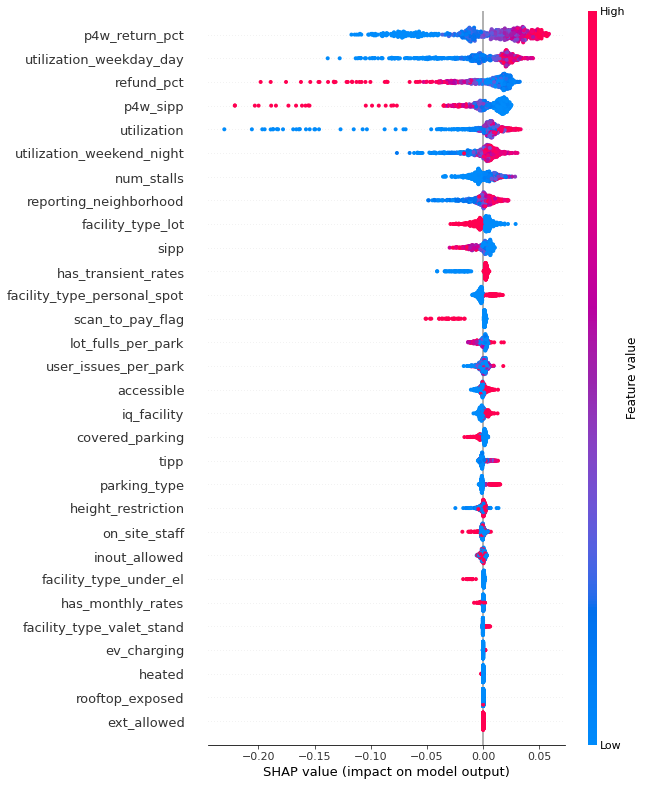

In [73]:
explainer = shap.Explainer(model.best_estimator_)
shap_values = explainer(df[features])
shap.plots.beeswarm(shap_values, max_display=len(features))

we can see the top 10 features that have the most contribution to the prediction are: <br>
- p4w_return_pct<br> 
- utilization_weekday_day<br> 
- refund_pct<br> 
- p4w_sipp<br>
- utilization<br>
- utilization_weekday_night<br>
- num_stalls<br>
- reporting_neighborhood<br>
- facility_type_lot<br>
- sipp<br>

Among them supply issues is a factor that can be improved by facility operators. also operators could find ways to reduce # of times a rental is returned/refunded.<br> 
In summary product team can recommend operators to work on these factors to effectively improve facility's rating on app.

Next steps: <br>
1. It's not fair to compare rating score with 1000 reviews with rating score with only 1 review. Usually the more reviews a rating has, the more trustworthy it is. To make the model more accurate, we can give different weights to a facility's rating based on number of reviews recieved on the app.<br>
2. a facility close to events may have different traits than normal ones, e.g, peak hours, rental fees, etc. We can build different models for event/non-event facilities, with different features, to measure their own quality.<br>
3. use other features and fine tune the model. E.g, we can include latitude and longitude as features and convert them to buckets.<br>
4. As mentioned previously, it's not fair to compare profitability of facilities in different neighborhood. so we can create models for each neighborhood, and use profit as label. This way we can predict a new facility's profit based on its location and operating conditions.<br>
5. utilization rate could also indicate a facility's quality. The higher utilization rate, the more it's welcomed by customers. so we can try model with utilization as label.